Loading json in memory ...
used time: 11.8664 s
Loading json in memory ...
creating index...
index created!
used time: 504.219 s
总共包含图片 49 张
第 1 张图片的高和宽分别为: (500, 318)
第 2 张图片的高和宽分别为: (480, 640)
第 3 张图片的高和宽分别为: (480, 640)
第 4 张图片的高和宽分别为: (400, 500)
第 5 张图片的高和宽分别为: (480, 640)
第 6 张图片的高和宽分别为: (364, 640)
第 7 张图片的高和宽分别为: (512, 640)
第 8 张图片的高和宽分别为: (500, 375)
第 9 张图片的高和宽分别为: (480, 640)
第 10 张图片的高和宽分别为: (640, 429)
第 11 张图片的高和宽分别为: (600, 518)
第 12 张图片的高和宽分别为: (640, 480)
第 13 张图片的高和宽分别为: (375, 500)
第 14 张图片的高和宽分别为: (375, 500)
第 15 张图片的高和宽分别为: (640, 480)
第 16 张图片的高和宽分别为: (426, 640)
第 17 张图片的高和宽分别为: (406, 500)
第 18 张图片的高和宽分别为: (480, 640)
第 19 张图片的高和宽分别为: (640, 543)
第 20 张图片的高和宽分别为: (640, 427)
第 21 张图片的高和宽分别为: (480, 640)
第 22 张图片的高和宽分别为: (640, 395)
第 23 张图片的高和宽分别为: (500, 375)
第 24 张图片的高和宽分别为: (640, 640)
第 25 张图片的高和宽分别为: (400, 500)
第 26 张图片的高和宽分别为: (375, 500)
第 27 张图片的高和宽分别为: (640, 428)
第 28 张图片的高和宽分别为: (640, 426)
第 29 张图片的高和宽分别为: (350, 500)
第 30 张图片的高和宽分别为: (334, 500)
第 31 张图片的高和宽分别为: (281, 500)


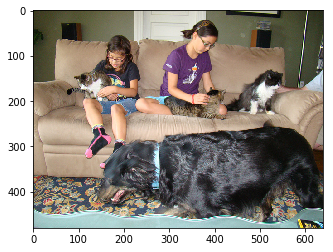

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# 载入 coco 相关 api
import sys
sys.path.append('../../cocoapi/PythonAPI')
from pycocotools.dataset import Loader
%matplotlib inline

dataType = 'train2017'
root = '../../data/coco'
catNms = ['cat', 'dog', 'person']  # 选择包含 'cat', 'dog', 'person' 的图片
annType = 'annotations_trainval2017'

loader = Loader(dataType, catNms, root, annType)

print(f'总共包含图片 {len(loader)} 张')

for i, ann in enumerate(loader.images):
    w, h = ann['height'], ann['width']
    print(f'第 {i+1} 张图片的高和宽分别为: {w, h}')

img, labels = loader[1]
plt.imshow(img);

In [2]:
img.shape

(480, 640, 3)

In [ ]:
img.transpose((2, 0, 1)).shape

In [ ]:
cd ../app/

In [ ]:
def getX(img):
    # 将 img (h, w, 3) 转换为 (1, 3, h, w)
    img = img.transpose((2, 0, 1))
    return np.expand_dims(img, 0)

In [ ]:
img, label = loader[0]
img = cv2.resize(img, (800, 800))
X = getX(img)
img.shape, X.shape

In [ ]:
from gluoncv.model_zoo import vgg16
from mxnet import nd
net = vgg16(pretrained=True)

imgs = nd.array(X)
x = imgs
for layer in net.features[:29]:
    x = layer(x)
    if "conv" in layer.name:
        print(layer.name, x.shape)

features = net.features[:29]
xs = features(imgs)
xs.shape

In [ ]:
from mxnet import init, gluon, autograd
from mxnet.gluon import nn


class RPNProposal(nn.HybridBlock):
    def __init__(self, channels, stride, base_size, ratios, scales, alloc_size, **kwargs):
        super().__init__(**kwargs)
        weight_initializer = init.Normal(0.01)

        with self.name_scope():
            self.anchor_generator = RPNAnchorGenerator(
                stride, base_size, ratios, scales, alloc_size)
            anchor_depth = self.anchor_generator.num_depth
            self.conv1 = nn.HybridSequential()
            self.conv1.add(nn.Conv2D(channels, 3, 1, 1,
                                     weight_initializer=weight_initializer))
            self.conv1.add(nn.Activation('relu'))
            # use sigmoid instead of softmax, reduce channel numbers
            self.score = nn.Conv2D(anchor_depth, 1, 1, 0,
                                   weight_initializer=weight_initializer)
            self.loc = nn.Conv2D(anchor_depth * 4, 1, 1, 0,
                                 weight_initializer=weight_initializer)


channels = 256
base_size = 2**4  # 特征图的每个像素的感受野大小
scales = [8, 16, 32]  # 锚框相对于 reference box 的尺度
ratios = [0.5, 1, 2]  # reference box 与锚框的高宽的比率（aspect ratios）
stride = base_size  # 在原图上滑动的步长
alloc_size = (128, 128)  # 一个比较大的特征图的锚框生成模板
alloc_size = (128, 128)  # 一个比较大的特征图的锚框生成模板
self = RPNProposal(channels, stride, base_size, ratios, scales, alloc_size)
self.initialize()

In [ ]:
imgs = []
labels = []
for img, label in loader:
    img = cv2.resize(img, (600, 800))  # resize 为 (600，800)
    plt.imshow(img);
    imgs.append(getX(img))
    labels.append(label)
imgs = nd.array(np.concatenate(imgs)) # 一个批量的图片
labels = nd.array(np.stack(labels))  # 一个批量的标注信息

In [ ]:
imgs.shape

In [ ]:
from gluoncv.nn.coder import NormalizedBoxCenterDecoder
from gluoncv.nn.bbox import BBoxCornerToCenter, BBoxClipToImage
stds = (0.1, 0.1, 0.2, 0.2)
means = (0., 0., 0., 0.)

fs = features(imgs)        # 获取特征图张量
F = nd
A = self.anchor_generator(fs)    # (xmin,ymin,xmax,ymax) 形式的锚框
box_to_center = BBoxCornerToCenter()  
B = box_to_center(A)      # (x,y,w,h) 形式的锚框
x = self.conv1(fs)    # conv1 卷积
raw_rpn_scores = self.score(x).transpose(axes=(0, 2, 3, 1)).reshape((0, -1,1))  # 激活之前的 score
rpn_scores = F.sigmoid(F.stop_gradient(raw_rpn_scores))    # 激活后的 score
rpn_box_pred = self.loc(x).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 4))  # loc 预测偏移量 (tx,ty,tw,yh)
box_decoder = NormalizedBoxCenterDecoder(stds, means)
roi = box_decoder(rpn_box_pred, B)  # 解码后的 G
print(roi.shape)
clipper = BBoxClipToImage()
roi = clipper(roi, imgs)  # 裁剪超出边界的边界

In [ ]:
min_size = 16  # 最小锚框的尺寸
xmin, ymin, xmax, ymax = roi.split(axis=-1, num_outputs=4) # 拆分坐标
width = xmax - xmin  # 锚框宽度的集合
height = ymax - ymin  # # 锚框高度的集合
invalid = (width < min_size) + (height < min_size) # 所有小于 min_size 的高宽
scores = F.where(invalid, F.ones_like(invalid) * -1, rpn_scores)
invalid = F.repeat(invalid, axis=-1, repeats=4)
rois = F.where(invalid, F.ones_like(invalid) * -1, roi)

In [ ]:
nms_thresh = 0.7
n_train_pre_nms = 12000  # 训练时 nms 之前的 bbox 的数目
n_train_post_nms = 2000  # 训练时 nms 之后的 bbox 的数目
n_test_pre_nms = 6000   # 测试时 nms 之前的 bbox 的数目
n_test_post_nms = 300   # 测试时 nms 之后的 bbox 的数目
min_size = 16  # 最小锚框的尺寸

nd..contrib.box_nms:

In [ ]:
%time
pre = F.concat(scores, rois, dim=-1)  # 合并 score 与 roi
# 非极大值抑制
tmp = F.contrib.box_nms(pre, overlap_thresh=nms_thresh, topk=n_train_pre_nms,
                        coord_start=1, score_index=0, id_index=-1, force_suppress=True)

# slice post_nms number of boxes
result = F.slice_axis(tmp, axis=1, begin=0, end=n_train_post_nms)
rpn_scores = F.slice_axis(result, axis=-1, begin=0, end=1)
rpn_bbox = F.slice_axis(result, axis=-1, begin=1, end=None)

rpn_bbox.shape, rpn_scores.shape

In [ ]:
scores = scores.flatten()  # 去除无效维度
orders = scores.argsort()[:,::-1]  # 将 scores 按照从大到小进行排序，并返回其索引
keep = orders[:,:n_train_pre_nms]

In [ ]:
order = keep[0]   # 第一张图片的得分降序索引
score = scores[0][order]  # 第一张图片的得分预测降序排列
roi = rois[0][order]     # 第一张图片的边界框预测按得分降序排列
label = labels[0]     # 真实边界框

效率低下：

In [ ]:
%%timeit
GT = [Box(corner) for corner in label]  # 真实边界框实例化
G = [Box(corner) for corner in roi]   # 预测边界框实例化
ious = nd.zeros((len(G), len(GT)))    #  初始化 IoU 的计算
for i, A in enumerate(G):
    for j, B in enumerate(GT):
        iou = A.IoU(B)
        ious[i, j] = iou

先转换为 Numpy 再计算 IoU 效率会更高：

In [ ]:
%%time
GT = [Box(corner) for corner in label.asnumpy()]  # 真实边界框实例化
G = [Box(corner) for corner in roi.asnumpy()]   # 预测边界框实例化
ious = nd.zeros((len(G), len(GT)))    #  初始化 IoU 的计算
for i, A in enumerate(G):
    for j, B in enumerate(GT):
        iou = A.IoU(B)
        ious[i, j] = iou

In [ ]:
%%timeit
GT = [Box(corner) for corner in label.asnumpy()]  # 真实边界框实例化
G = [Box(corner) for corner in roi.asnumpy()]   # 预测边界框实例化
ious = np.zeros((len(G), len(GT)))    #  初始化 IoU 的计算
for i, A in enumerate(G):
    for j, B in enumerate(GT):
        iou = A.IoU(B)
        ious[i, j] = iou

In [ ]:
def group_ious(pred_bbox, true_bbox):
    # 计算 pred_bbox 与 true_bbox 的 IoU 组合
    GT = [Box(corner) for corner in true_bbox]  # 真实边界框实例化
    G = [Box(corner) for corner in pred_bbox]   # 预测边界框实例化
    ious = np.zeros((len(G), len(GT)))    #  初始化 IoU 的计算
    for i, A in enumerate(G):
        for j, B in enumerate(GT):
            iou = A.IoU(B)
            ious[i, j] = iou
    return ious

In [ ]:
ious = group_ious(roi.asnumpy(), label.asnumpy())

In [ ]:
wh = labels[:,:,2:4]
labels[:,:,2:4] = labels[:,:,:2] + (wh-1)*0.5

In [ ]:
class BoxTransform(Box):
    '''
    一组 bbox 的运算
    '''
    def __init__(self, F, corners):
        '''
        F 可以是 mxnet.nd, numpy, torch.tensor
        '''
        super().__init__(corners)
        self.corner = corners.T
        self.F = F

    def __and__(self, other):
        r'''
        运算符 `&` 交集运算
        '''
        xmin = self.F.maximum(self.corner[0].expand_dims(
            0), other.corner[0].expand_dims(1))  # xmin 中的大者
        xmax = self.F.minimum(self.corner[2].expand_dims(
            0), other.corner[2].expand_dims(1))  # xmax 中的小者
        ymin = self.F.maximum(self.corner[1].expand_dims(
            0), other.corner[1].expand_dims(1))  # ymin 中的大者
        ymax = self.F.minimum(self.corner[3].expand_dims(
            0), other.corner[3].expand_dims(1))  # ymax 中的小者
        w = xmax - xmin
        h = ymax - ymin
        cond = (w <= 0) + (h <= 0)
        I = self.F.where(cond, nd.zeros_like(cond), w * h)
        return I

    def __or__(self, other):
        r'''
        运算符 `|` 并集运算
        '''
        I = self & other
        U = self.area.expand_dims(0) + other.area.expand_dims(1) - I
        return self.F.where(U < 0, self.F.zeros_like(I), U)

    def IoU(self, other):
        '''
        交并比
        '''
        I = self & other
        U = self | other
        return self.F.where(U == 0, self.F.zeros_like(I), I / U)

In [ ]:
a = BoxTransform(nd, nd.array([[[0, 0, 15, 15]]]))
b = BoxTransform(nd, 1+nd.array([[[0, 0, 15, 15]]]))
c = BoxTransform(nd, nd.array([[[-1, -1, -1, -1]]]))

a & b, a | b, a.IoU(b)

In [ ]:
a & c, a | c, a.IoU(c)

In [ ]:
def nms(dets, thresh):
    # boxes 位置
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    # boxes scores
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)  # 各 box 的面积
    order = scores.argsort()[::-1]  # boxes 的按照 score 排序

    keep = []  # 记录保留下的 boxes
    while order.size > 0:
        i = order[0]  # score 最大的 box 对应的 index
        keep.append(i)  # 将本轮 score 最大的 box 的 index 保留

        # 计算剩余 boxes 与当前 box 的重叠程度 IoU
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)  # IoU
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        # 保留 IoU 小于设定阈值的 boxes
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep